<a href="https://colab.research.google.com/github/sadiaanzum/MLDLS_2022/blob/main/Assignment-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.csv to test (3).csv
Saving train.csv to train (3).csv
User uploaded file "test.csv" with length 28629 bytes
User uploaded file "train.csv" with length 61194 bytes


# **Task 1**

## **Importing necessary Libraries**

In [82]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

## for explainer
from lime import lime_tabular

In [84]:
data=pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## **EDA**

**Aim:** To get an overview of the whole dataset, that is:
how many categorical and numerical variables are there, how many missing values or rows we have.

Writing a function to determine whether the column is numerical or categorical and will accordingly return "num" or "cat". As arguments, we will take the raw input data, the name of the column to be analysed and the maximum number of unique values.

In [85]:
 def utils_recognize_type(data, col, max_cat=20):
    if (data[col].dtype == "O") | (data[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

Let's plot a heatmap to visualise the data: column types and missing data.

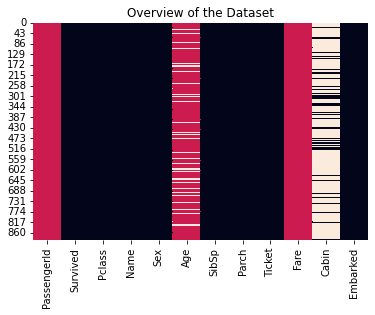

 Categerocial   Numerical   NaN 


In [86]:
dic_cols={col:utils_recognize_type(data, col, max_cat=20) for col in data.columns}
heatmap = data.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Overview of the Dataset')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numerical ", "\033[1;30;47m NaN ")

In [87]:
data.shape

(891, 12)

What we can analyse so far:


*   *PassengerID* is the column that will uniquely identify every passenger.
*   Our Target Variable is Survived which gives the prediction if the passenger survived or not. This is our "Y" column or the dependent variable. 

*   Columns that have Numerical Data: *PassengerID, Age, Fare*
*   Columns having missing data: *Age*, *Cabin*






In [88]:
data = data.set_index("PassengerId")
data = data.rename(columns={"Survived":"Y"})  #renaming Survived Column as Y for easy reference


Plotting the Target Variable

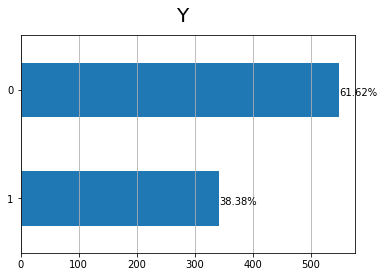

In [89]:
y = "Y"
ax = data[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()

Here, 

0 = No which means the passenger did not survive 

1 = Yes which means yes, the passenger surived.

The Bar plot shows that more than 500 passengers didn't survive and upto 300 passengers survived.

As indicated, the survival rate is roughly 38%

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


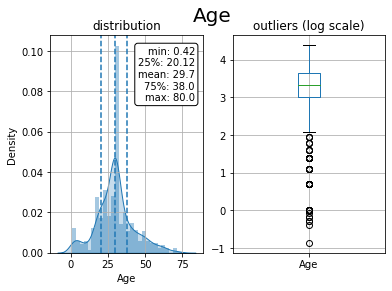

In [90]:
x = "Age"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)

### distribution
ax[0].title.set_text('distribution')
variable = data[x].fillna(data[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = data[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_data = pd.DataFrame(data[x])
tmp_data[x] = np.log(tmp_data[x])
tmp_data.boxplot(column=x, ax=ax[1])
plt.show()

On average, the passengers were young as indicated by Mean (about 30 years) and the Third Quartile (38 years). 

Looking at the box plot, the outliers range from below 2, meaning there were many children (toddlers and infants) aboard.

Can the variable *Age* significantly predict the outcome (that is, *y*)?

Let's analyse.

(Note: *Y* is **Categorical** and *Age* is **Numerical** so we will have some work to do)

Instead of visualizing for this step, let's use a one-way ANOVA test. 

This step will test whether the means of two or more independent samples are significantly different. So, if the p-value is very small ( <0.05) then the null hypothesis of samples means equality can be rejected.

In [91]:
cat, num = "Y", "Age"
model = smf.ols(num+' ~ '+cat, data=data).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.039)


This means our assumption is true that the passenger's age significantly determined survival chances. 

Going by the Rescue Code "Women and Children First", we also have to check in the same way how gender determined survival chances. 

Note: this case is categorical (Y) vs categorical (Sex).


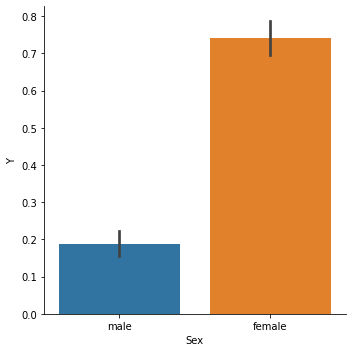

In [92]:
sns.catplot(x="Sex", y="Y", kind="bar", data=data)

We see that about 75% of the total amount of women onboard and less than 20% male passengers survived the Titanic Sinking. 

In other words, the survival rate among women is 75% and among men is 20%, therefore Sex is predictive. 

This also confirms that priority was given rescuing women and children first. 

Let's check missing values in the columns


In [93]:
data.isnull().sum()

Y             0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Out of 891 rows, Age column has 177 missing values (roughly about 20% of total data), so it should not be of much concern to us. But since Age is one of the predictive columns we have to impugn missing values with mean.

However, Column Cabin has 687 rows missing. To think of it, the Columns Cabin, Fare and Ticket Number will not be of much value since:


*   Fare is only the price of the ticket and will definitely not affect the survival chances.
*   Cabin is merely the cabin number which too would not be significant to predict survival.

*   Ticket Number will uniquely identify the passenger's stay in ship and does not affect survival.

Hence we will drop these columns.





In [94]:

data.drop('Fare', axis=1, inplace=True)
data.drop('Cabin', axis=1, inplace=True)
data.drop('Ticket', axis=1, inplace=True)

In [95]:
#dropping Name column
data.drop('Name', axis=1, inplace=True)

In [101]:
data.drop('Embarked', axis=1, inplace=True)

In [102]:
data.head() #Columns have been dropped

,Y,Pclass,Age,SibSp,Parch,Sex_male
PassengerId,,,,,,
1,0,3,22.0,1,0,1
2,1,1,38.0,1,0,0
3,1,3,26.0,0,0,0
4,1,1,35.0,1,0,0
5,0,3,35.0,0,0,1


In [103]:
#impugning missing data values in Age column

data["Age"] = data["Age"].fillna(data["Age"].mean())

In [98]:
data.isnull().sum()

Y           0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    2
dtype: int64

In [99]:
#Encoding categorical data i.e.- Sex Column 

## creating dummy
dummy = pd.get_dummies(data["Sex"], 
                       prefix="Sex",drop_first=True)
data= pd.concat([data, dummy], axis=1)
print( data.filter(like="Sex", axis=1).head() )
## drop the original categorical column
data.drop("Sex", axis=1, inplace=True)

                Sex  Sex_male
PassengerId                  
1              male         1
2            female         0
3            female         0
4            female         0
5              male         1


Instead of having a categorical value, we are simply putting the column as a Binary variable (Is the Passenger Male? Yes=1, No=0)

In [104]:
# Scaling the Features

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(data.drop("Y", axis=1))
data_scaled= pd.DataFrame(X, columns=data.drop("Y", axis=1).columns, index=data.index)
data_scaled["Y"] = data["Y"]
data_scaled.head()

,Pclass,Age,SibSp,Parch,Sex_male,Y
PassengerId,,,,,,
1,1.0,0.271174,0.125,0.0,1.0,0
2,0.0,0.472229,0.125,0.0,0.0,1
3,1.0,0.321438,0.000,0.0,0.0,1
4,0.0,0.434531,0.125,0.0,0.0,1
5,1.0,0.434531,0.000,0.0,1.0,0


Let's Split the data into Train and Test sets and proceed to train on models

In [108]:
## split data
data_scaled, data_test = model_selection.train_test_split(data_scaled, 
                      test_size=0.3)
## print info
print("X_train shape:", data_scaled.drop("Y",axis=1).shape, "| X_test shape:", data_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(data_scaled["Y"]),2), "| y_test mean:", round(np.mean(data_test["Y"]),2))
print(data_scaled.shape[1], "features:", data_scaled.drop("Y",axis=1).columns.to_list())

X_train shape: (623, 5) | X_test shape: (268, 5)
y_train mean: 0.37 | y_test mean: 0.41
6 features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Sex_male']


In [109]:
X_names = ["Age", "Sex_male", "SibSp", "Pclass", "Parch"]

X_train = data_scaled[X_names].values
y_train = data_scaled["Y"].values

X_test = data_test[X_names].values
y_test = data_test["Y"].values

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear'))
model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())


**Model Evaluation**

In [114]:

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

model_list=['Logistic Regression','SVM', 'KNN','Decision Tree']
acc_list =[]
auc_list=[]
cm_list=[]

for model in model_pipeline: 
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc_list.append(metrics.accuracy_score(y_test,y_pred))
  fpr,tpr, _thresholds = metrics.roc_curve(y_test,y_pred)
  auc_list.append(round(metrics.auc(fpr,tpr),2))
  cm_list.append(confusion_matrix(y_test,y_pred))

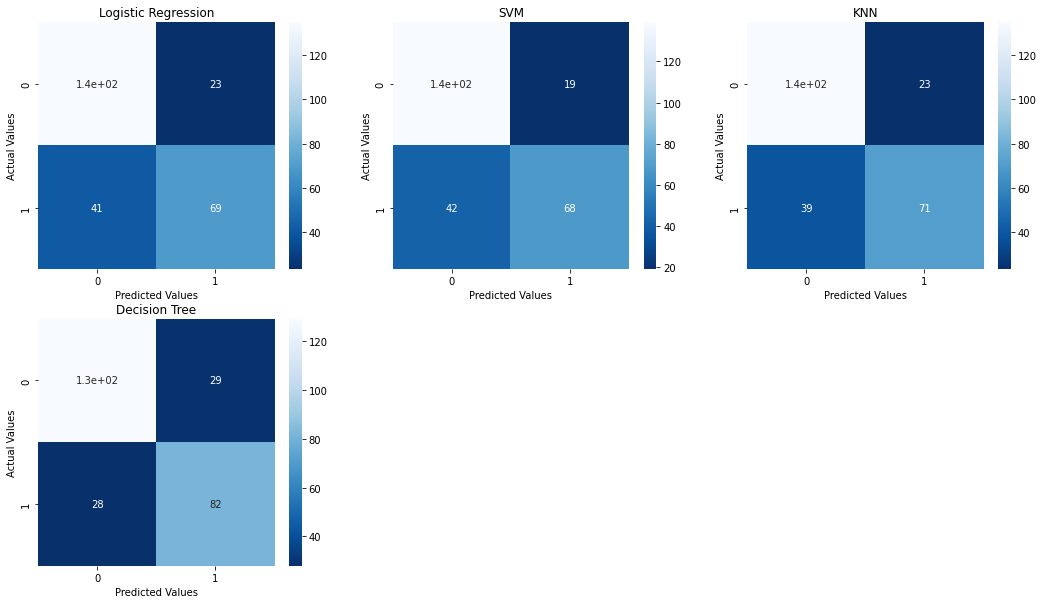

In [116]:
#plot confusion matrix
fig = plt.figure(figsize =(18,10))
for i in range(len(cm_list)):
  cm=cm_list[i]
  model=model_list[i]
  sub=fig.add_subplot(2,3,i+1).set_title(model)
  cm_plot=sns.heatmap(cm,annot=True, cmap='Blues_r')
  cm_plot.set_xlabel('Predicted Values')
  cm_plot.set_ylabel('Actual Values')

In [117]:
#accuracy and AUC
result_df = pd.DataFrame({'Model': model_list, 'Accuracy': acc_list, 'AUC': auc_list})
result_df

,Model,Accuracy,AUC
0,Logistic Regression,0.761194,0.74
1,SVM,0.772388,0.75
2,KNN,0.768657,0.75
3,Decision Tree,0.787313,0.78


# **Task 2**

In [118]:
from sklearn.cluster import KMeans

In [119]:
X_names_Kmeans = ["Age", "Sex_male"]

X_train_Kmeans = data_scaled[X_names_Kmeans].values


X_test_Kmeans = data_test[X_names_Kmeans].values


In [130]:
kmean=KMeans(n_clusters=2)
kmean.fit(X_train_Kmeans)

KMeans(n_clusters=2)

In [131]:
kmean.cluster_centers_


array([[3.85817782e-01, 1.00000000e+00],
       [3.46622419e-01, 2.22044605e-15]])

In [132]:
kmean.labels_

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Cluster 1 Inertia 158.4867090111382
Cluster 2 Inertia 16.551495766744857
Cluster 3 Inertia 10.151856592071574
Cluster 4 Inertia 6.7701881503822126
Cluster 5 Inertia 4.631691368700944
Cluster 6 Inertia 3.108516015270823
Cluster 7 Inertia 2.4108295879463055
Cluster 8 Inertia 1.8103491063325619
Cluster 9 Inertia 1.3177017955202088
Cluster 10 Inertia 1.0529732431855405
Cluster 11 Inertia 0.7855535414391172
Cluster 12 Inertia 0.6784268452473635
Cluster 13 Inertia 0.5719613514191421
Cluster 14 Inertia 0.4738218415201214
Cluster 15 Inertia 0.40951654737471826
Cluster 16 Inertia 0.360206162460611
Cluster 17 Inertia 0.33144914759468946
Cluster 18 Inertia 0.2880470423524949
Cluster 19 Inertia 0.26521799975204896


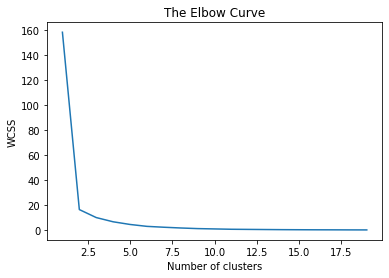

In [137]:
wcss = []
for i in range(1,20):
 kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
 kmeans.fit(X_train_Kmeans)
 wcss.append(kmeans.inertia_)
 print("Cluster", i, "Inertia", kmeans.inertia_)
plt.plot(range(1,20),wcss)
plt.title('The Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') ##WCSS stands for total within-cluster sum of square
plt.show()

In [138]:
k_means_optimum = KMeans(n_clusters = 2, init = 'k-means++',  random_state=42)
y = k_means_optimum.fit_predict(X_test_Kmeans)
print(y)

[0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0
 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0
 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0
 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0
 0 1 0 1 1 0 1 1 0]
